In [ ]:
%pip install "monai==1.4.1rc1" -q

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
#%pip uninstall -y numpy
#%pip install "numpy==1.26.4"

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.


In [ ]:
import pandas as pd

In [ ]:
import glob
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [ ]:
import nibabel as nib
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
from monai.config import print_config
from monai.metrics import DiceMetric
from monai.data import DataLoader, Dataset, decollate_batch
from monai.losses import DiceLoss
from monai.networks.nets import SwinUNETR
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    LoadImage,
    Resize,
    ScaleIntensity,
    ToTensor,
    Lambda,
    EnsureType,
)
from monai.utils import set_determinism
from monai.inferers import sliding_window_inference

In [ ]:
print_config()

MONAI version: 1.4.1rc1
Numpy version: 1.26.4
Pytorch version: 2.6.0+cu124
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: e604d1841fe60c0ffb6978ae4116535ca8d8f34f
MONAI __file__: /usr/local/lib/python3.11/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.2
scikit-image version: 0.25.2
scipy version: 1.16.0
Pillow version: 11.3.0
Tensorboard version: 2.18.0
gdown version: 5.2.0
TorchVision version: 0.21.0+cu124
tqdm version: 4.67.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.2.2
einops version: 0.8.1
transformers version: 4.54.0
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/e

In [ ]:
# --- 1. Data Preparation with image_size=160 ---
image_dir = "/content/drive/MyDrive/MNI_train_data/image_files"
label_dir = "/content/drive/MyDrive/MNI_train_data/label_files_combined"



In [ ]:
lut_path = "/content/drive/MyDrive/FreeSurferColorLUT.txt"

In [ ]:
images = sorted(glob.glob(os.path.join(image_dir, "*.nii.gz")))
labels = sorted(glob.glob(os.path.join(label_dir, "*.nii.gz")))

In [ ]:
def visualize_image(mri_image, label_image, slice_num, array = False):

  if array == False:
    mri_image = nib.load(mri_image).get_fdata()
    label_image =nib.load(label_image).get_fdata()

  df = pd.read_csv(lut_path,sep='\s+', comment = '#', names = ['Label_ID', 'Label_Name', 'R', 'G', 'B', 'A'], usecols = ['Label_ID', 'Label_Name', 'R', 'G', 'B'])

  unique_labels = np.unique(label_image)

  rgb_img = np.zeros((*label_image.shape, 3), dtype = np.uint8)

  for labels in unique_labels:
     rgb_values = df.loc[df['Label_ID'] == labels, ['R', 'G', 'B']].values[0]
     rgb_img[label_image == labels] = rgb_values

  fig, axs = plt.subplots(1, 3, figsize = (15, 15))
  axs[0].imshow(mri_image[slice_num,: ,:], cmap = 'gray')
  axs[0].set_title('MRI Slice')
  axs[0].axis('off')

  axs[1].imshow(rgb_img[slice_num, :, :, :])
  axs[1].set_title('Label Slice')
  axs[1].axis('off')

  axs[2].imshow(mri_image[slice_num, :, :], cmap = 'gray')
  axs[2].imshow(rgb_img[slice_num, :, :, :], alpha = 0.5)
  axs[2].set_title('Overlay')
  axs[2].axis('off')

  plt.show()


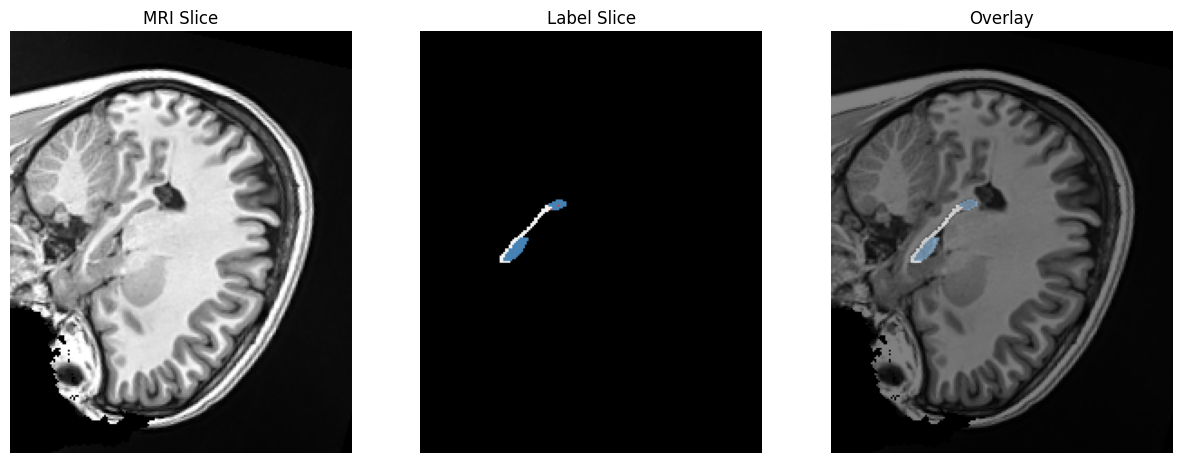

In [ ]:
visualize_image(images[0],labels[0], 75)

In [ ]:
from monai.transforms import SpatialCrop, CenterSpatialCrop

In [ ]:

img_size=(160, 160, 160)

In [ ]:
img_transforms = Compose([
    LoadImage(image_only=True), ToTensor(), ScaleIntensity(),
    EnsureChannelFirst(), CenterSpatialCrop(roi_size=img_size)
])
seg_transforms = Compose([
    LoadImage(image_only=True), ToTensor(),
    EnsureChannelFirst(), CenterSpatialCrop(roi_size=img_size)
])


In [ ]:
class MyBrainDataset(Dataset):
    def __init__(self, data, img_tfms, seg_tfms):
        super().__init__(data)
        self.img_tfms = img_tfms
        self.seg_tfms = seg_tfms
    def __getitem__(self, idx):
        d = self.data[idx]
        image = self.img_tfms(d["image"])
        label = self.seg_tfms(d["label"])
        return image, label


In [ ]:
data_dicts = [{"image": i, "label": s} for i, s in zip(images, labels)]
train_files = data_dicts[:4]
val_files   = data_dicts[4:]


In [ ]:
train_ds = MyBrainDataset(train_files, img_transforms, seg_transforms)
val_ds   = MyBrainDataset(val_files,   img_transforms, seg_transforms)


In [ ]:
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=1, shuffle=False, num_workers=2)


In [ ]:
imgt, segt = train_ds[0]
imgt = imgt.squeeze().numpy()
segt = segt.squeeze().numpy()
imgt.shape, segt.shape

((160, 160, 160), (160, 160, 160))

In [ ]:
from monai.losses import DiceCELoss
from collections import OrderedDict
set_determinism(seed=40)

# --- 2. Model Initialization with img_size=160 and feature_size=24 ---
model = SwinUNETR(
    img_size=(160, 160, 160), # <-- MODIFIED as per your request
    in_channels=1,
    out_channels=4,
    feature_size=24,
    use_checkpoint=True,
).cuda()
model_dict = model.state_dict()

pretrained_path = "/content/drive/MyDrive/swin_tiny_patch4_window7_224.pth"
pretrained_weights = torch.load(pretrained_path)["model"]

# --- Visualize Model State Dicts ---
print("--- Pretrained Swin-T Layer Names and Shapes (Sample) ---")
for i, (k, v) in enumerate(pretrained_weights.items()):
    if i >= 15: break
    print(f"{k:<70} Shape: {v.shape}")

print("\n--- Target Swin UNETR Layer Names and Shapes (Sample) ---")
for i, (k, v) in enumerate(model_dict.items()):
    if i >= 15: break
    print(f"{k:<70} Shape: {v.shape}")
print("-" * 80)


# --- 3. Weight Transfer with Slicing (Same as before) ---
def map_weights_with_slicing(pretrained_state, model_state):
    new_state_dict = OrderedDict()
    transferred_count = 0
    print("--- Starting Weight Transfer with Slicing ---")

    for pretrained_key, pretrained_value in pretrained_state.items():
        new_key = pretrained_key
        if new_key.startswith('layers.0'): new_key = new_key.replace('layers.0', 'swinViT.layers1.0', 1)
        elif new_key.startswith('layers.1'): new_key = new_key.replace('layers.1', 'swinViT.layers2.0', 1)
        elif new_key.startswith('layers.2'): new_key = new_key.replace('layers.2', 'swinViT.layers3.0', 1)
        elif new_key.startswith('layers.3'): new_key = new_key.replace('layers.3', 'swinViT.layers4.0', 1)
        elif new_key.startswith('patch_embed.'): new_key = new_key.replace('patch_embed.', 'swinViT.patch_embed.', 1)
        elif new_key.startswith('norm.'): new_key = new_key.replace('norm.', 'swinViT.norm.', 1)
        new_key = new_key.replace('mlp.fc1.', 'mlp.linear1.')
        new_key = new_key.replace('mlp.fc2.', 'mlp.linear2.')
        new_key = new_key.replace('downsample.reduction.', 'downsample.proj.')

        if any(x in new_key for x in ["head", "relative_position", "decoder", "out."]):
            continue

        if new_key in model_state:
            target_tensor = model_state[new_key]
            if "swinViT.patch_embed.proj.weight" in new_key:
                # Average the 3 RGB channels to a single channel
                adapted_weight = pretrained_value.mean(dim=1, keepdim=True)
                # Inflate the weights to 3D
                inflated_weight = adapted_weight.unsqueeze(2).repeat(1, 1, target_tensor.shape[2], 1, 1)
                if inflated_weight.shape == target_tensor.shape:
                    new_state_dict[new_key] = inflated_weight
                    transferred_count += 1
                    print(f"  -> Success (weight inflation).")
                else:
                    print(f"  -> !!! Mismatch after weight inflation. Skipping.")
            elif pretrained_value.shape == target_tensor.shape:
                new_state_dict[new_key] = pretrained_value
                transferred_count += 1
            else:
                print(f"Slicing '{new_key}': From {pretrained_value.shape} to {target_tensor.shape}")
                slices = tuple(slice(0, t) for t in target_tensor.shape)
                try:
                    sliced_value = pretrained_value[slices]
                    if sliced_value.shape == target_tensor.shape:
                        new_state_dict[new_key] = sliced_value
                        transferred_count += 1
                        print(f"  -> Success.")
                    else:
                        print(f"  -> !!! Mismatch after slicing. Skipping.")
                except Exception as e:
                    print(f"  -> !!! Slicing failed: {e}. Skipping.")

    print(f"--- Finished Weight Transfer ---")
    return new_state_dict, transferred_count

mapped_weights, num_transferred = map_weights_with_slicing(pretrained_weights, model_dict)
model.load_state_dict(mapped_weights, strict=False)

print(f"\nSuccessfully transferred and/or sliced {num_transferred} / {len(model_dict)} layers.")

# --- 5. Print Summary ---
total_model_params = sum(p.numel() for p in model.parameters())
transferred_params = sum(p.numel() for p in mapped_weights.values())
total_pretrained_params = sum(p.numel() for p in pretrained_weights.values())
percentage_params_transferred = (transferred_params / total_model_params) * 100 if total_model_params > 0 else 0

total_model_layers = len(model_dict)
percentage_layers_transferred = (num_transferred / total_model_layers) * 100

print(f"--- Weight Transfer Summary ---")
print(f"Total Parameters in Swin-T (Pretrained): {total_pretrained_params:,}")
print(f"Total Parameters in Swin UNETR (Target):  {total_model_params:,}")
print(f"Parameters Transferred: {transferred_params:,}")
print("-" * 35)
print(f"Total Layers in Swin UNETR: {total_model_layers}")
print(f"Layers Updated: {num_transferred}")
print(f"Percentage of Layers Updated: {percentage_layers_transferred:.2f}%")
print(f"Percentage of Parameters Updated: {percentage_params_transferred:.2f}%")

--- Pretrained Swin-T Layer Names and Shapes (Sample) ---
patch_embed.proj.weight                                                Shape: torch.Size([96, 3, 4, 4])
patch_embed.proj.bias                                                  Shape: torch.Size([96])
patch_embed.norm.weight                                                Shape: torch.Size([96])
patch_embed.norm.bias                                                  Shape: torch.Size([96])
layers.0.blocks.0.norm1.weight                                         Shape: torch.Size([96])
layers.0.blocks.0.norm1.bias                                           Shape: torch.Size([96])
layers.0.blocks.0.attn.qkv.weight                                      Shape: torch.Size([288, 96])
layers.0.blocks.0.attn.qkv.bias                                        Shape: torch.Size([288])
layers.0.blocks.0.attn.proj.weight                                     Shape: torch.Size([96, 96])
layers.0.blocks.0.attn.proj.bias                                    

In [ ]:
from monai.metrics import HausdorffDistanceMetric, SurfaceDistanceMetric

loss_function = DiceCELoss(to_onehot_y=True, softmax=True, lambda_dice=0.7, lambda_ce=0.3, include_background=True)

trainable_params = [param for param in model.parameters() if param.requires_grad]
optimizer = torch.optim.AdamW(trainable_params, lr=1e-3)
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 50, 70], gamma=0.1)

dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)

hd95_metric = HausdorffDistanceMetric(include_background=False, percentile=95.0, reduction="mean")
asd_metric = SurfaceDistanceMetric(include_background=False, reduction="mean")

post_trans = Compose([
    Activations(softmax=True),
    AsDiscrete(argmax=True, to_onehot=4)
])

to_onehot = AsDiscrete(to_onehot=4)

In [ ]:
def save_best_model(model, best_model_path):
    torch.save(model.state_dict(), best_model_path)


In [ ]:
def load_model(model, path):
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

In [ ]:
def save_checkpoint(epoch, model, optimizer, loss, dice_mean, epoch_list, val_dice_list, hd95_list, asd_list, train_loss_list, best_metric, best_metric_epoch, checkpoint_path):
    checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss,
    'dice_mean': dice_mean,
    'epoch_list' : epoch_list,
    'val_dice_list' : val_dice_list,
    'train_loss_list' : train_loss_list,
    'hd95_list': hd95_list,
    'asd_list': asd_list,
    'best_metric': best_metric,
    'best_metric_epoch': best_metric_epoch,
    }
    torch.save(checkpoint, checkpoint_path)


In [ ]:
def load_checkpoint(path):
    checkpoint = torch.load(path, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    dice_mean = checkpoint['dice_mean']
    epoch_list = checkpoint['epoch_list']
    val_dice_list = checkpoint['val_dice_list']
    hd95_list = checkpoint['hd95_list']
    asd_list = checkpoint['asd_list']
    train_loss_list = checkpoint['train_loss_list']
    best_metric = checkpoint['best_metric']
    best_metric_epoch = checkpoint['best_metric_epoch']
    return epoch, model, optimizer, loss, dice_mean, epoch_list, val_dice_list, hd95_list, asd_list, train_loss_list, best_metric, best_metric_epoch

In [ ]:
epoch, model, optimizer, loss, dice_mean, epoch_list, val_dice_list, hd95_list, asd_list, train_loss_list, best_metric, best_metric_epoch = load_checkpoint('/content/Train_Data_INFO_Biplav/Cross_Validation/Fewshot_4/Fold_Checkpoint.pth')

FileNotFoundError: [Errno 2] No such file or directory: '/content/Train_Data_INFO_Biplav/Cross_Validation/Fewshot_4/Fold_Checkpoint.pth'

In [ ]:
max_epochs = 200
val_interval = 10

In [ ]:

train_loss_list = []
val_dice_list   = []
epoch_list      = []
hd95_list = []
asd_list  = []
epoch=0
dice_mean = -1
best_metric = -1
best_metric_epoch = -1


In [ ]:
from tqdm import tqdm

In [ ]:
start_epoch=epoch

In [ ]:
import torch.nn.functional as F

In [ ]:
import os
from pathlib import Path  # More modern path handling

# Define paths using Path for better cross-platform compatibility
checkpoint_path = Path('Train_Data_INFO_Biplav/Cross_Validation/Fewshot_12/Fold4_Checkpoint.pth')
best_model_path = Path('Train_Data_INFO_Biplav/Cross_Validation/Fewshot_12/Fold4_best_dice_model.pth')

# Create parent directories if they don't exist
checkpoint_path.parent.mkdir(parents=True, exist_ok=True)
best_model_path.parent.mkdir(parents=True, exist_ok=True)

# You can then use str() when you need string paths for PyTorch saving:
torch.save(model.state_dict(), str(best_model_path))

In [ ]:
#Training Loop
for epoch in range( max_epochs):
    print(f"Epoch [{epoch+1}/{max_epochs}] {datetime.datetime.now()}")
    model.train()
    epoch_loss = 0

    for batch_data in tqdm(train_loader, leave=False):
        inputs, label = batch_data[0].cuda(), batch_data[1].cuda()

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, label)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)
    #scheduler.step()
    train_loss_list.append(epoch_loss)
    print(f"  Train loss: {epoch_loss:.4f}")



    # Validation Loop
    if (epoch + 1) % val_interval == 0:
        model.eval()
        dice_vals = []
        with torch.no_grad():
            for val_data in tqdm(val_loader, leave=False):
                val_inputs, val_labels = val_data[0].cuda(), val_data[1].cuda()
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model, mode="gaussian", overlap=0.5)
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                dice_metric(y_pred=val_outputs, y=val_labels)

                val_labels_onehot = [to_onehot(i) for i in decollate_batch(val_labels)]

                hd95_metric(y_pred=val_outputs, y=val_labels_onehot)
                asd_metric(y_pred=val_outputs, y=val_labels_onehot)


        dice_mean = dice_metric.aggregate().item()
        dice_metric.reset()


        hd95_mean = hd95_metric.aggregate().item()
        asd_mean  = asd_metric.aggregate().item()
        hd95_metric.reset()
        asd_metric.reset()

        hd95_list.append(hd95_mean)
        asd_list.append(asd_mean)

        val_dice_list.append(dice_mean)
        epoch_list.append(epoch + 1)
        print(f"  Validation Dice: {dice_mean:.4f}")
        print(f"  Validation HD95 : {hd95_mean:.4f} mm")
        print(f"  Validation ASD  : {asd_mean:.4f} mm")

        # Save the best model
        if dice_mean > best_metric:
            best_metric = dice_mean
            best_HD95 = hd95_mean
            best_ASD  = asd_mean
            best_metric_epoch = epoch + 1
            save_best_model(model, best_model_path)
            print("   Saved new best model")



    save_checkpoint(epoch, model, optimizer, loss, dice_mean, epoch_list, val_dice_list, hd95_list, asd_list, train_loss_list, best_metric, best_metric_epoch, checkpoint_path)
print(f"\nTraining complete. Best val Dice: {best_metric:.4f}, HD95: {best_HD95}, ASD: {best_ASD} at epoch {best_metric_epoch}")


Epoch [1/200] 2025-07-29 16:51:50.058533


  Train loss: 1.1318
Epoch [2/200] 2025-07-29 16:52:01.025746


  Train loss: 0.9277
Epoch [3/200] 2025-07-29 16:52:09.948666


  Train loss: 0.8691
Epoch [4/200] 2025-07-29 16:52:18.937731


  Train loss: 0.8364
Epoch [5/200] 2025-07-29 16:52:27.914332


  Train loss: 0.8141
Epoch [6/200] 2025-07-29 16:52:37.576676


  Train loss: 0.7965
Epoch [7/200] 2025-07-29 16:52:46.629816


  Train loss: 0.7810
Epoch [8/200] 2025-07-29 16:52:55.747644


  Train loss: 0.7670
Epoch [9/200] 2025-07-29 16:53:04.880843


  Train loss: 0.7545
Epoch [10/200] 2025-07-29 16:53:14.643078


  Train loss: 0.7431


  0%|          | 0/21 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/monai/metrics/utils.py:335: UserWarning: the prediction of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/monai/metrics/utils.py:335: UserWarning: the prediction of class 1 is all 0, this may result in nan/inf distance.
  warnings.warn(


  Validation Dice: 0.2496
  Validation HD95 : 86.5070 mm
  Validation ASD  : inf mm
   Saved new best model
Epoch [11/200] 2025-07-29 16:54:10.650614


  Train loss: 0.7323
Epoch [12/200] 2025-07-29 16:54:19.868790


  Train loss: 0.7224
Epoch [13/200] 2025-07-29 16:54:29.103725


  Train loss: 0.7131
Epoch [14/200] 2025-07-29 16:54:38.359704


  Train loss: 0.7044
Epoch [15/200] 2025-07-29 16:54:47.552942


  Train loss: 0.6958
Epoch [16/200] 2025-07-29 16:54:56.720388


  Train loss: 0.6879
Epoch [17/200] 2025-07-29 16:55:05.869471


  Train loss: 0.6797
Epoch [18/200] 2025-07-29 16:55:14.971054


  Train loss: 0.6711
Epoch [19/200] 2025-07-29 16:55:24.073235


  Train loss: 0.6638
Epoch [20/200] 2025-07-29 16:55:33.795866


  Train loss: 0.6570


  0%|          | 0/21 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/monai/metrics/utils.py:335: UserWarning: the prediction of class 2 is all 0, this may result in nan/inf distance.
  warnings.warn(


  Validation Dice: 0.2497
  Validation HD95 : 112.0232 mm
  Validation ASD  : inf mm
   Saved new best model
Epoch [21/200] 2025-07-29 16:55:59.257198


  Train loss: 0.6503
Epoch [22/200] 2025-07-29 16:56:09.307097


  Train loss: 0.6440
Epoch [23/200] 2025-07-29 16:56:18.462314


  Train loss: 0.6382
Epoch [24/200] 2025-07-29 16:56:27.616336


  Train loss: 0.6328
Epoch [25/200] 2025-07-29 16:56:36.778851


  Train loss: 0.6277
Epoch [26/200] 2025-07-29 16:56:46.548916


  Train loss: 0.6226
Epoch [27/200] 2025-07-29 16:56:55.688326


  Train loss: 0.6178
Epoch [28/200] 2025-07-29 16:57:04.829089


  Train loss: 0.6117
Epoch [29/200] 2025-07-29 16:57:13.948440


  Train loss: 0.6066
Epoch [30/200] 2025-07-29 16:57:23.727911


  Train loss: 0.6009


  Validation Dice: 0.3577
  Validation HD95 : 14.7382 mm
  Validation ASD  : 5.9399 mm
   Saved new best model
Epoch [31/200] 2025-07-29 16:57:51.267741


  Train loss: 0.5944
Epoch [32/200] 2025-07-29 16:58:01.352681


  Train loss: 0.5891
Epoch [33/200] 2025-07-29 16:58:10.584675


  Train loss: 0.5848
Epoch [34/200] 2025-07-29 16:58:19.792924


  Train loss: 0.5800
Epoch [35/200] 2025-07-29 16:58:28.977650


  Train loss: 0.5760
Epoch [36/200] 2025-07-29 16:58:38.716337


  Train loss: 0.5721
Epoch [37/200] 2025-07-29 16:58:47.928482


  Train loss: 0.5679
Epoch [38/200] 2025-07-29 16:58:57.130906


  Train loss: 0.5643
Epoch [39/200] 2025-07-29 16:59:06.355190


  Train loss: 0.5606
Epoch [40/200] 2025-07-29 16:59:15.584862


  Train loss: 0.5568


  Validation Dice: 0.4081
  Validation HD95 : 9.4501 mm
  Validation ASD  : inf mm
   Saved new best model
Epoch [41/200] 2025-07-29 16:59:41.952275


  Train loss: 0.5534
Epoch [42/200] 2025-07-29 16:59:51.147564


  Train loss: 0.5489
Epoch [43/200] 2025-07-29 17:00:00.368197


  Train loss: 0.5447
Epoch [44/200] 2025-07-29 17:00:09.558875


  Train loss: 0.5409
Epoch [45/200] 2025-07-29 17:00:18.782003


  Train loss: 0.5377
Epoch [46/200] 2025-07-29 17:00:27.984096


  Train loss: 0.5338
Epoch [47/200] 2025-07-29 17:00:37.195773


  Train loss: 0.5298
Epoch [48/200] 2025-07-29 17:00:46.362300


  Train loss: 0.5275
Epoch [49/200] 2025-07-29 17:00:55.537650


  Train loss: 0.5244
Epoch [50/200] 2025-07-29 17:01:04.701638


  Train loss: 0.5196


  Validation Dice: 0.5113
  Validation HD95 : 4.4617 mm
  Validation ASD  : inf mm
   Saved new best model
Epoch [51/200] 2025-07-29 17:01:31.145445


  Train loss: 0.5158
Epoch [52/200] 2025-07-29 17:01:40.335138


  Train loss: 0.5128
Epoch [53/200] 2025-07-29 17:01:49.551862


  Train loss: 0.5077
Epoch [54/200] 2025-07-29 17:01:58.745159


  Train loss: 0.5039
Epoch [55/200] 2025-07-29 17:02:08.001047


  Train loss: 0.4985
Epoch [56/200] 2025-07-29 17:02:17.188520


  Train loss: 0.4938
Epoch [57/200] 2025-07-29 17:02:26.418382


  Train loss: 0.4884
Epoch [58/200] 2025-07-29 17:02:35.602980


  Train loss: 0.4835
Epoch [59/200] 2025-07-29 17:02:44.787594


  Train loss: 0.4776
Epoch [60/200] 2025-07-29 17:02:53.993060


  Train loss: 0.4709


  Validation Dice: 0.5363
  Validation HD95 : 3.9599 mm
  Validation ASD  : inf mm
   Saved new best model
Epoch [61/200] 2025-07-29 17:03:20.552261


  Train loss: 0.4660
Epoch [62/200] 2025-07-29 17:03:29.727546


  Train loss: 0.4608
Epoch [63/200] 2025-07-29 17:03:38.979523


  Train loss: 0.4500
Epoch [64/200] 2025-07-29 17:03:48.217926


  Train loss: 0.4422
Epoch [65/200] 2025-07-29 17:03:57.431350


  Train loss: 0.4337
Epoch [66/200] 2025-07-29 17:04:06.614592


  Train loss: 0.4239
Epoch [67/200] 2025-07-29 17:04:16.427996


  Train loss: 0.4143
Epoch [68/200] 2025-07-29 17:04:25.612595


  Train loss: 0.4047
Epoch [69/200] 2025-07-29 17:04:34.791099


  Train loss: 0.3967
Epoch [70/200] 2025-07-29 17:04:44.281118


  Train loss: 0.3876


  Validation Dice: 0.5590
  Validation HD95 : 3.1116 mm
  Validation ASD  : inf mm
   Saved new best model
Epoch [71/200] 2025-07-29 17:05:11.293553


  Train loss: 0.3731
Epoch [72/200] 2025-07-29 17:05:20.477912


  Train loss: 0.3651
Epoch [73/200] 2025-07-29 17:05:30.320788


  Train loss: 0.3604
Epoch [74/200] 2025-07-29 17:05:39.591523


  Train loss: 0.3502
Epoch [75/200] 2025-07-29 17:05:48.827332


  Train loss: 0.3426
Epoch [76/200] 2025-07-29 17:05:58.034166


  Train loss: 0.3370
Epoch [77/200] 2025-07-29 17:06:07.429700


  Train loss: 0.3289
Epoch [78/200] 2025-07-29 17:06:16.676747


  Train loss: 0.3184
Epoch [79/200] 2025-07-29 17:06:25.866101


  Train loss: 0.3137
Epoch [80/200] 2025-07-29 17:06:35.109496


  Train loss: 0.3049


  Validation Dice: 0.5837
  Validation HD95 : 4.6139 mm
  Validation ASD  : inf mm
   Saved new best model
Epoch [81/200] 2025-07-29 17:07:02.261557


  Train loss: 0.2993
Epoch [82/200] 2025-07-29 17:07:11.473066


  Train loss: 0.2926
Epoch [83/200] 2025-07-29 17:07:21.025194


  Train loss: 0.2888
Epoch [84/200] 2025-07-29 17:07:30.231379


  Train loss: 0.2836
Epoch [85/200] 2025-07-29 17:07:39.448883


  Train loss: 0.2768
Epoch [86/200] 2025-07-29 17:07:48.656392


  Train loss: 0.2695
Epoch [87/200] 2025-07-29 17:07:58.486638


  Train loss: 0.2652
Epoch [88/200] 2025-07-29 17:08:07.677575


  Train loss: 0.2641
Epoch [89/200] 2025-07-29 17:08:16.908970


  Train loss: 0.2644
Epoch [90/200] 2025-07-29 17:08:26.112909


  Train loss: 0.2646


  Validation Dice: 0.6034
  Validation HD95 : 6.4195 mm
  Validation ASD  : 1.7224 mm
   Saved new best model
Epoch [91/200] 2025-07-29 17:08:53.836177


  Train loss: 0.2569
Epoch [92/200] 2025-07-29 17:09:03.075741


  Train loss: 0.2566
Epoch [93/200] 2025-07-29 17:09:12.544614


  Train loss: 0.2514
Epoch [94/200] 2025-07-29 17:09:21.795410


  Train loss: 0.2459
Epoch [95/200] 2025-07-29 17:09:31.062543


  Train loss: 0.2406
Epoch [96/200] 2025-07-29 17:09:40.271089


  Train loss: 0.2368
Epoch [97/200] 2025-07-29 17:09:49.511730


  Train loss: 0.2335
Epoch [98/200] 2025-07-29 17:09:58.735854


  Train loss: 0.2310
Epoch [99/200] 2025-07-29 17:10:07.958868


  Train loss: 0.2296
Epoch [100/200] 2025-07-29 17:10:17.184416


  Train loss: 0.2261


  Validation Dice: 0.7383
  Validation HD95 : 4.8643 mm
  Validation ASD  : 1.2499 mm
   Saved new best model
Epoch [101/200] 2025-07-29 17:10:45.184937


  Train loss: 0.2247
Epoch [102/200] 2025-07-29 17:10:54.369659


  Train loss: 0.2240
Epoch [103/200] 2025-07-29 17:11:03.611166


  Train loss: 0.2234
Epoch [104/200] 2025-07-29 17:11:12.846661


  Train loss: 0.2178
Epoch [105/200] 2025-07-29 17:11:22.072438


  Train loss: 0.2126
Epoch [106/200] 2025-07-29 17:11:31.274481


  Train loss: 0.2078
Epoch [107/200] 2025-07-29 17:11:40.469842


  Train loss: 0.2051
Epoch [108/200] 2025-07-29 17:11:49.698438


  Train loss: 0.1966
Epoch [109/200] 2025-07-29 17:11:58.903920


  Train loss: 0.1932
Epoch [110/200] 2025-07-29 17:12:08.112233


  Train loss: 0.1891


  Validation Dice: 0.7374
  Validation HD95 : 4.1093 mm
  Validation ASD  : 1.1158 mm
Epoch [111/200] 2025-07-29 17:12:35.242337


  Train loss: 0.1857
Epoch [112/200] 2025-07-29 17:12:44.443867


  Train loss: 0.1911
Epoch [113/200] 2025-07-29 17:12:53.705162


  Train loss: 0.1780
Epoch [114/200] 2025-07-29 17:13:02.942231


  Train loss: 0.1861
Epoch [115/200] 2025-07-29 17:13:12.188172


  Train loss: 0.1752
Epoch [116/200] 2025-07-29 17:13:21.396895


  Train loss: 0.1672
Epoch [117/200] 2025-07-29 17:13:30.612071


  Train loss: 0.1615
Epoch [118/200] 2025-07-29 17:13:39.849679


  Train loss: 0.1472
Epoch [119/200] 2025-07-29 17:13:49.066559


  Train loss: 0.1334
Epoch [120/200] 2025-07-29 17:13:58.274409


  Train loss: 0.1274


  Validation Dice: 0.7376
  Validation HD95 : 2.6930 mm
  Validation ASD  : 0.8037 mm
Epoch [121/200] 2025-07-29 17:14:24.863893


  Train loss: 0.1283
Epoch [122/200] 2025-07-29 17:14:34.077132


  Train loss: 0.1154
Epoch [123/200] 2025-07-29 17:14:43.317030


  Train loss: 0.1106
Epoch [124/200] 2025-07-29 17:14:53.183690


  Train loss: 0.0992
Epoch [125/200] 2025-07-29 17:15:02.409436


  Train loss: 0.0981
Epoch [126/200] 2025-07-29 17:15:11.604714


  Train loss: 0.0896
Epoch [127/200] 2025-07-29 17:15:20.835737


  Train loss: 0.0908
Epoch [128/200] 2025-07-29 17:15:30.645681


  Train loss: 0.0890
Epoch [129/200] 2025-07-29 17:15:39.849479


  Train loss: 0.0891
Epoch [130/200] 2025-07-29 17:15:49.106472


  Train loss: 0.0763


  Validation Dice: 0.7568
  Validation HD95 : 2.9695 mm
  Validation ASD  : 0.9862 mm
   Saved new best model
Epoch [131/200] 2025-07-29 17:16:18.751022


  Train loss: 0.0722
Epoch [132/200] 2025-07-29 17:16:28.025676


  Train loss: 0.0695
Epoch [133/200] 2025-07-29 17:16:37.288170


  Train loss: 0.0684
Epoch [134/200] 2025-07-29 17:16:46.521871


  Train loss: 0.0645
Epoch [135/200] 2025-07-29 17:16:55.757666


  Train loss: 0.0596
Epoch [136/200] 2025-07-29 17:17:04.957830


  Train loss: 0.0588
Epoch [137/200] 2025-07-29 17:17:14.139194


  Train loss: 0.0614
Epoch [138/200] 2025-07-29 17:17:23.305966


  Train loss: 0.0623
Epoch [139/200] 2025-07-29 17:17:32.454790


  Train loss: 0.0628
Epoch [140/200] 2025-07-29 17:17:41.653071


  Train loss: 0.0647


  Validation Dice: 0.7548
  Validation HD95 : 2.9128 mm
  Validation ASD  : 0.8772 mm
Epoch [141/200] 2025-07-29 17:18:09.590232


  Train loss: 0.0602
Epoch [142/200] 2025-07-29 17:18:18.887148


  Train loss: 0.0520
Epoch [143/200] 2025-07-29 17:18:28.250480


  Train loss: 0.0536
Epoch [144/200] 2025-07-29 17:18:37.647635


  Train loss: 0.0544
Epoch [145/200] 2025-07-29 17:18:47.636713


  Train loss: 0.0554
Epoch [146/200] 2025-07-29 17:18:57.028021


  Train loss: 0.0527
Epoch [147/200] 2025-07-29 17:19:06.375299


  Train loss: 0.0531
Epoch [148/200] 2025-07-29 17:19:15.730153


  Train loss: 0.0465
Epoch [149/200] 2025-07-29 17:19:25.710841


  Train loss: 0.0420
Epoch [150/200] 2025-07-29 17:19:35.093280


  Train loss: 0.0388


  Validation Dice: 0.7571
  Validation HD95 : 2.9138 mm
  Validation ASD  : 0.8846 mm
   Saved new best model
Epoch [151/200] 2025-07-29 17:20:02.576537


  Train loss: 0.0393
Epoch [152/200] 2025-07-29 17:20:11.866391


  Train loss: 0.0357
Epoch [153/200] 2025-07-29 17:20:21.185063


  Train loss: 0.0343
Epoch [154/200] 2025-07-29 17:20:30.523829


  Train loss: 0.0328
Epoch [155/200] 2025-07-29 17:20:39.867537


  Train loss: 0.0329
Epoch [156/200] 2025-07-29 17:20:49.193042


  Train loss: 0.0319
Epoch [157/200] 2025-07-29 17:20:58.537640


  Train loss: 0.0307
Epoch [158/200] 2025-07-29 17:21:08.093840


  Train loss: 0.0291
Epoch [159/200] 2025-07-29 17:21:17.377610


  Train loss: 0.0296
Epoch [160/200] 2025-07-29 17:21:26.678866


  Train loss: 0.0317


  Validation Dice: 0.7556
  Validation HD95 : 2.9288 mm
  Validation ASD  : 0.8969 mm
Epoch [161/200] 2025-07-29 17:21:54.180341


  Train loss: 0.0346
Epoch [162/200] 2025-07-29 17:22:04.100376


  Train loss: 0.0331
Epoch [163/200] 2025-07-29 17:22:13.407283


  Train loss: 0.0320
Epoch [164/200] 2025-07-29 17:22:22.739269


  Train loss: 0.0389
Epoch [165/200] 2025-07-29 17:22:32.028496


  Train loss: 0.0347
Epoch [166/200] 2025-07-29 17:22:41.960402


  Train loss: 0.0361
Epoch [167/200] 2025-07-29 17:22:51.223252


  Train loss: 0.0363
Epoch [168/200] 2025-07-29 17:23:00.504180


  Train loss: 0.0409
Epoch [169/200] 2025-07-29 17:23:09.764791


  Train loss: 0.0385
Epoch [170/200] 2025-07-29 17:23:19.672677


  Train loss: 0.0320


  Validation Dice: 0.7571
  Validation HD95 : 2.8905 mm
  Validation ASD  : 0.8995 mm
   Saved new best model
Epoch [171/200] 2025-07-29 17:23:47.839102


  Train loss: 0.0296
Epoch [172/200] 2025-07-29 17:23:57.138886


  Train loss: 0.0267
Epoch [173/200] 2025-07-29 17:24:06.455555


  Train loss: 0.0281
Epoch [174/200] 2025-07-29 17:24:15.736890


  Train loss: 0.0304
Epoch [175/200] 2025-07-29 17:24:25.097091


  Train loss: 0.0290
Epoch [176/200] 2025-07-29 17:24:34.417700


  Train loss: 0.0309
Epoch [177/200] 2025-07-29 17:24:43.680599


  Train loss: 0.0302
Epoch [178/200] 2025-07-29 17:24:52.912696


  Train loss: 0.0342
Epoch [179/200] 2025-07-29 17:25:02.168883


  Train loss: 0.0297
Epoch [180/200] 2025-07-29 17:25:11.427880


  Train loss: 0.0291


  Validation Dice: 0.7576
  Validation HD95 : 2.6661 mm
  Validation ASD  : 0.8276 mm
   Saved new best model
Epoch [181/200] 2025-07-29 17:25:39.576002


  Train loss: 0.0280
Epoch [182/200] 2025-07-29 17:25:48.858584


  Train loss: 0.0297
Epoch [183/200] 2025-07-29 17:25:58.391878


  Train loss: 0.0266
Epoch [184/200] 2025-07-29 17:26:07.660667


  Train loss: 0.0250
Epoch [185/200] 2025-07-29 17:26:16.939522


  Train loss: 0.0221
Epoch [186/200] 2025-07-29 17:26:26.175981


  Train loss: 0.0213
Epoch [187/200] 2025-07-29 17:26:36.046231


  Train loss: 0.0202
Epoch [188/200] 2025-07-29 17:26:45.322079


  Train loss: 0.0208
Epoch [189/200] 2025-07-29 17:26:54.523202


  Train loss: 0.0209
Epoch [190/200] 2025-07-29 17:27:03.776380


  Train loss: 0.0238


  Validation Dice: 0.7543
  Validation HD95 : 2.8954 mm
  Validation ASD  : 0.9101 mm
Epoch [191/200] 2025-07-29 17:27:32.444310


  Train loss: 0.0211
Epoch [192/200] 2025-07-29 17:27:41.696035


  Train loss: 0.0241
Epoch [193/200] 2025-07-29 17:27:51.540166


  Train loss: 0.0221
Epoch [194/200] 2025-07-29 17:28:00.801006


  Train loss: 0.0219
Epoch [195/200] 2025-07-29 17:28:10.082312


  Train loss: 0.0227
Epoch [196/200] 2025-07-29 17:28:19.337967


  Train loss: 0.0209
Epoch [197/200] 2025-07-29 17:28:28.619609


  Train loss: 0.0209
Epoch [198/200] 2025-07-29 17:28:37.888225


  Train loss: 0.0226
Epoch [199/200] 2025-07-29 17:28:47.145778


  Train loss: 0.0198
Epoch [200/200] 2025-07-29 17:28:56.423283


  Train loss: 0.0187


  Validation Dice: 0.7545
  Validation HD95 : 2.7762 mm
  Validation ASD  : 0.8576 mm

Training complete. Best val Dice: 0.7576, HD95: 2.6661386489868164, ASD: 0.8275553584098816 at epoch 180


In [ ]:
len(train_loss_list), len(val_dice_list), len(epoch_list)


(200, 20, 20)

In [ ]:
from matplotlib import rcParams

rcParams['font.weight'] = 'bold'

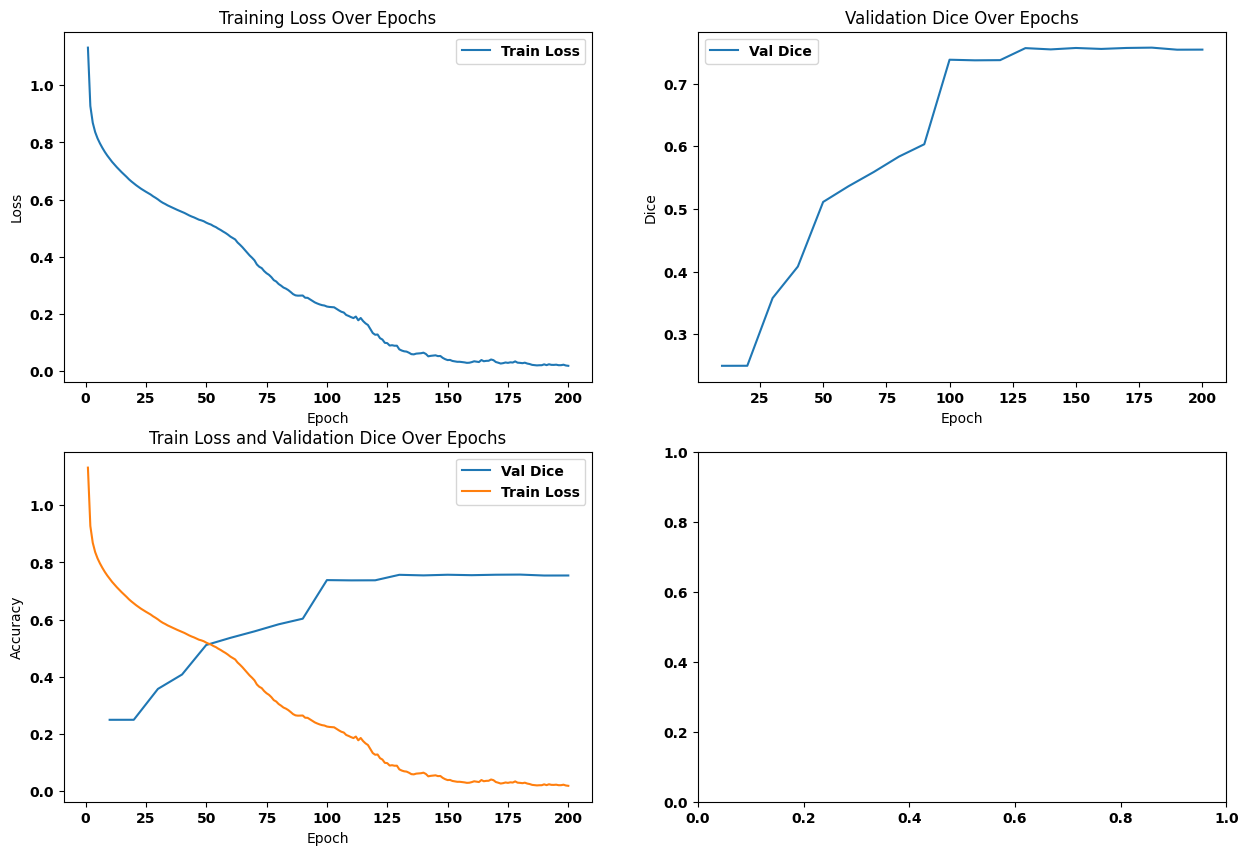

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs[0 ,0].plot(range(1, max_epochs+1), train_loss_list, label="Train Loss")
axs[0, 0].set_xlabel("Epoch")
axs[0, 0].set_ylabel("Loss")
axs[0, 0].set_title("Training Loss Over Epochs")
axs[0, 0].legend()

axs[0, 1].plot(epoch_list, val_dice_list, label="Val Dice")
axs[0, 1].set_xlabel("Epoch")
axs[0, 1].set_ylabel("Dice")
axs[0, 1].set_title("Validation Dice Over Epochs")
axs[0, 1].legend()

"""
axs[1, 0].plot(range(1, max_epochs+1), 1 - np.array(train_loss_list[:]), label="Train Accuracy")
axs[1, 0].set_xlabel("Epoch")
axs[1, 0].set_ylabel("Accuracy")
axs[1, 0].set_title("Training Accuracy Over Epochs")
axs[1, 0].legend()
"""

axs[1, 0].plot(epoch_list, val_dice_list, label="Val Dice")
axs[1, 0].plot(range(1, max_epochs+1), train_loss_list, label="Train Loss")
axs[1, 0].set_xlabel("Epoch")
axs[1, 0].set_ylabel("Accuracy")
axs[1, 0].set_title("Train Loss and Validation Dice Over Epochs")
axs[1, 0].legend()

plt.show()


In [ ]:
new_val_list = val_dice_list*10
new_hd95_list = hd95_list*10
new_asd_list = asd_list*10

In [ ]:
df = pd.DataFrame({'Max_Epoch': epoch,
                     "Epoch_list": range(1, max_epochs+1),
                     "Validation_List": new_val_list,
                     "HD95_List": new_hd95_list,
                     "ASD_List": new_asd_list,
                     "Train_Loss_List": train_loss_list,
                     "Best_Dice": best_metric,
                     "Best_Dice_Epoch": best_metric_epoch,
                    "Best_HD95": best_HD95,
                    "Best_ASD": best_ASD})

file_path = "/content/drive/MyDrive/Train_Data_INFO2/Cross4__Tuning_data_info.csv"

df.to_csv(file_path, index=False)
print(f"File saved to: {os.path.abspath(file_path)}")

File saved to: /content/drive/MyDrive/Train_Data_INFO2/Cross4__Tuning_data_info.csv


In [ ]:
os.listdir()

In [ ]:
%cd -

In [ ]:
num_classes=4

In [ ]:
# Model Evaluation
model.load_state_dict(torch.load(best_model_path))
model.eval()

def dice_score(pred, target, num_classes):
    """
    Calculate Dice score for each class and the combined hippocampus structure.
    """
    dice_scores = torch.zeros(num_classes, device=pred.device)

    for class_idx in range(num_classes):
        pred_mask = (pred == class_idx).float()
        target_mask = (target == class_idx).float()

        intersection = (pred_mask * target_mask).sum()
        pred_volume = pred_mask.sum()
        target_volume = target_mask.sum()

        if pred_volume + target_volume == 0:
            dice_scores[class_idx] = 1.0
        else:
            dice_scores[class_idx] = (2 * intersection) / (pred_volume + target_volume)

    hippocampus_classes = [1, 2, 3]
    pred_hippocampus = torch.zeros_like(pred, device=pred.device)
    target_hippocampus = torch.zeros_like(target, device=target.device)

    for class_idx in hippocampus_classes:
        pred_hippocampus = pred_hippocampus + (pred == class_idx).float()
        target_hippocampus = target_hippocampus + (target == class_idx).float()

    pred_hippocampus = (pred_hippocampus > 0).float()
    target_hippocampus = (target_hippocampus > 0).float()

    intersection = (pred_hippocampus * target_hippocampus).sum()
    pred_volume = pred_hippocampus.sum()
    target_volume = target_hippocampus.sum()

    if pred_volume + target_volume == 0:
        hippocampus_dice = 1.0
    else:
        hippocampus_dice = (2 * intersection) / (pred_volume + target_volume)

    return dice_scores, hippocampus_dice

# Validation with Dice, HD95, and ASD
test_dice_list = []
test_hd95_list = []
test_asd_list = []
class_dice = {'hippocampus': [], 'CA1': [], 'CA4DG': [], 'subiculum': []}
class_hd95 = {'hippocampus': [], 'CA1': [], 'CA4DG': [], 'subiculum': []}
class_asd = {'hippocampus': [], 'CA1': [], 'CA4DG': [], 'subiculum': []}

to_onehot = AsDiscrete(to_onehot=num_classes)

with torch.no_grad():
    for val_data in val_loader:
        val_inputs, val_labels = val_data[0].cuda(), val_data[1].cuda()
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model, mode="gaussian", overlap=0.5)

        # Convert logits to one-hot format
        val_outputs_post = [post_trans(i) for i in decollate_batch(val_outputs)]
        val_labels_onehot = [to_onehot(i) for i in decollate_batch(val_labels)]

        # Convert to class indices for Dice score computation
        val_outputs_indices = torch.argmax(val_outputs, dim=1)

        # Calculate Dice scores
        dice_scores, hippocampus_dice = dice_score(val_outputs_indices, val_labels, num_classes=4)
        class_dice['hippocampus'].append(hippocampus_dice.item())
        class_dice['CA1'].append(dice_scores[1].item())
        class_dice['CA4DG'].append(dice_scores[2].item())
        class_dice['subiculum'].append(dice_scores[3].item())
        test_dice_list.append(dice_scores.mean().item())

        # Compute overall HD95 and ASD
        hd95_metric(y_pred=val_outputs_post, y=val_labels_onehot)
        asd_metric(y_pred=val_outputs_post, y=val_labels_onehot)
        test_hd95_list.append(hd95_metric.aggregate().item())
        test_asd_list.append(asd_metric.aggregate().item())
        hd95_metric.reset()
        asd_metric.reset()

        # Compute per-class HD95 and ASD
        for class_idx in [1, 2, 3]:
            pred_mask = (val_outputs_indices == class_idx).float()  # Shape: [1, 160, 160, 160]
            target_mask = (val_labels == class_idx).float()        # Shape: [1, 160, 160, 160]
            # Convert to one-hot format: [num_classes, 160, 160, 160]
            pred_onehot = torch.zeros((num_classes, 160, 160, 160), device=pred_mask.device)
            target_onehot = torch.zeros((num_classes, 160, 160, 160), device=target_mask.device)
            for i in range(num_classes):
                pred_onehot[i] = (pred_mask == i).float().squeeze(0)  # Squeeze batch dim
                target_onehot[i] = (target_mask == i).float().squeeze(0)  # Squeeze batch dim
            hd95_metric(y_pred=[pred_onehot], y=[target_onehot])
            asd_metric(y_pred=[pred_onehot], y=[target_onehot])
            class_hd95[['CA1', 'CA4DG', 'subiculum'][class_idx-1]].append(hd95_metric.aggregate().item())
            class_asd[['CA1', 'CA4DG', 'subiculum'][class_idx-1]].append(asd_metric.aggregate().item())
            hd95_metric.reset()
            asd_metric.reset()

        # Compute hippocampus combined HD95 and ASD
        hippocampus_classes = [1, 2, 3]
        pred_hippocampus = torch.zeros_like(val_outputs_indices, device=val_outputs_indices.device)
        target_hippocampus = torch.zeros_like(val_labels, device=val_labels.device)
        for class_idx in hippocampus_classes:
            pred_hippocampus = pred_hippocampus + (val_outputs_indices == class_idx).float()
            target_hippocampus = target_hippocampus + (val_labels == class_idx).float()
        pred_hippocampus = (pred_hippocampus > 0).float()  # Shape: [1, 160, 160, 160]
        target_hippocampus = (target_hippocampus > 0).float()  # Shape: [1, 160, 160, 160]
        # Convert to one-hot format for binary (background vs. hippocampus): [2, 160, 160, 160]
        pred_hippocampus_onehot = torch.zeros((2, 160, 160, 160), device=pred_hippocampus.device)
        target_hippocampus_onehot = torch.zeros((2, 160, 160, 160), device=target_hippocampus.device)
        pred_hippocampus_onehot[0] = (pred_hippocampus == 0).float().squeeze(0)
        pred_hippocampus_onehot[1] = pred_hippocampus.squeeze(0)
        target_hippocampus_onehot[0] = (target_hippocampus == 0).float().squeeze(0)
        target_hippocampus_onehot[1] = target_hippocampus.squeeze(0)
        hd95_metric(y_pred=[pred_hippocampus_onehot], y=[target_hippocampus_onehot])
        asd_metric(y_pred=[pred_hippocampus_onehot], y=[target_hippocampus_onehot])
        class_hd95['hippocampus'].append(hd95_metric.aggregate().item())
        class_asd['hippocampus'].append(asd_metric.aggregate().item())
        hd95_metric.reset()
        asd_metric.reset()

        print(f"Validation - Mean Dice: {test_dice_list[-1]:.4f}, HD95: {test_hd95_list[-1]:.4f}, ASD: {test_asd_list[-1]:.4f}")
        print(f"Hippocampus: Dice: {class_dice['hippocampus'][-1]:.4f}, HD95: {class_hd95['hippocampus'][-1]:.4f}, ASD: {class_asd['hippocampus'][-1]:.4f}")
        print(f"CA1: Dice: {class_dice['CA1'][-1]:.4f}, HD95: {class_hd95['CA1'][-1]:.4f}, ASD: {class_asd['CA1'][-1]:.4f}")
        print(f"CA4DG: Dice: {class_dice['CA4DG'][-1]:.4f}, HD95: {class_hd95['CA4DG'][-1]:.4f}, ASD: {class_asd['CA4DG'][-1]:.4f}")
        print(f"Subiculum: Dice: {class_dice['subiculum'][-1]:.4f}, HD95: {class_hd95['subiculum'][-1]:.4f}, ASD: {class_asd['subiculum'][-1]:.4f}\n")

# Calculate final statistics
def get_stats(values):
    return np.mean(values), np.std(values)

overall_dice_mean, overall_dice_std = get_stats(test_dice_list)
hippocampus_dice_mean, hippocampus_dice_std = get_stats(class_dice['hippocampus'])
ca1_dice_mean, ca1_dice_std = get_stats(class_dice['CA1'])
ca4dg_dice_mean, ca4dg_dice_std = get_stats(class_dice['CA4DG'])
sub_dice_mean, sub_dice_std = get_stats(class_dice['subiculum'])

overall_hd95_mean, overall_hd95_std = get_stats(test_hd95_list)
hippocampus_hd95_mean, hippocampus_hd95_std = get_stats(class_hd95['hippocampus'])
ca1_hd95_mean, ca1_hd95_std = get_stats(class_hd95['CA1'])
ca4dg_hd95_mean, ca4dg_hd95_std = get_stats(class_hd95['CA4DG'])
sub_hd95_mean, sub_hd95_std = get_stats(class_hd95['subiculum'])

overall_asd_mean, overall_asd_std = get_stats(test_asd_list)
hippocampus_asd_mean, hippocampus_asd_std = get_stats(class_asd['hippocampus'])
ca1_asd_mean, ca1_asd_std = get_stats(class_asd['CA1'])
ca4dg_asd_mean, ca4dg_asd_std = get_stats(class_asd['CA4DG'])
sub_asd_mean, sub_asd_std = get_stats(class_asd['subiculum'])

print("\nFinal Test Metrics:")
print(f"Overall: Dice: {overall_dice_mean:.4f} ± {overall_dice_std:.4f}, HD95: {overall_hd95_mean:.4f} ± {overall_hd95_std:.4f}, ASD: {overall_asd_mean:.4f} ± {overall_asd_std:.4f}")
print(f"Hippocampus: Dice: {hippocampus_dice_mean:.4f} ± {hippocampus_dice_std:.4f}, HD95: {hippocampus_hd95_mean:.4f} ± {hippocampus_hd95_std:.4f}, ASD: {hippocampus_asd_mean:.4f} ± {hippocampus_asd_std:.4f}")
print(f"CA1: Dice: {ca1_dice_mean:.4f} ± {ca1_dice_std:.4f}, HD95: {ca1_hd95_mean:.4f} ± {ca1_hd95_std:.4f}, ASD: {ca1_asd_mean:.4f} ± {ca1_asd_std:.4f}")
print(f"CA4DG: Dice: {ca4dg_dice_mean:.4f} ± {ca4dg_dice_std:.4f}, HD95: {ca4dg_hd95_mean:.4f} ± {ca4dg_hd95_std:.4f}, ASD: {ca4dg_asd_mean:.4f} ± {ca4dg_asd_std:.4f}")
print(f"Subiculum: Dice: {sub_dice_mean:.4f} ± {sub_dice_std:.4f}, HD95: {sub_hd95_mean:.4f} ± {sub_hd95_std:.4f}, ASD: {sub_asd_mean:.4f} ± {sub_asd_std:.4f}")

/usr/local/lib/python3.11/dist-packages/monai/metrics/utils.py:330: UserWarning: the ground truth of class 1 is all 0, this may result in nan/inf distance.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/monai/metrics/utils.py:330: UserWarning: the ground truth of class 2 is all 0, this may result in nan/inf distance.
  warnings.warn(


Validation - Mean Dice: 0.8239, HD95: 1.7454, ASD: 0.5339
Hippocampus: Dice: 0.8540, HD95: 2.2361, ASD: 0.5824
CA1: Dice: 0.7390, HD95: 2.0000, ASD: 0.6241
CA4DG: Dice: 0.7467, HD95: 2.2361, ASD: 0.5592
Subiculum: Dice: 0.8103, HD95: 1.0000, ASD: 0.4183

Validation - Mean Dice: 0.7342, HD95: 2.4317, ASD: 1.1290
Hippocampus: Dice: 0.8094, HD95: 2.2361, ASD: 1.3652
CA1: Dice: 0.6713, HD95: 2.4495, ASD: 1.1928
CA4DG: Dice: 0.6062, HD95: 2.4495, ASD: 1.4554
Subiculum: Dice: 0.6598, HD95: 2.3961, ASD: 0.7389

Validation - Mean Dice: 0.7793, HD95: 2.1574, ASD: 0.6268
Hippocampus: Dice: 0.8543, HD95: 2.0000, ASD: 0.5818
CA1: Dice: 0.7348, HD95: 2.0000, ASD: 0.5659
CA4DG: Dice: 0.6919, HD95: 2.2361, ASD: 0.6448
Subiculum: Dice: 0.6910, HD95: 2.2361, ASD: 0.6698

Validation - Mean Dice: 0.7505, HD95: 3.4930, ASD: 0.9199
Hippocampus: Dice: 0.8072, HD95: 3.4051, ASD: 0.9335
CA1: Dice: 0.6934, HD95: 3.3166, ASD: 0.9297
CA4DG: Dice: 0.6017, HD95: 4.0000, ASD: 0.9679
Subiculum: Dice: 0.7074, HD95: 3

In [ ]:
individual_data = pd.DataFrame({
    'Mean Dice': test_dice_list,
    'Mean HD95': test_hd95_list,
    'Mean ASD': test_asd_list,
    'Dice Hippocampus': class_dice['hippocampus'],
    'Dice CA1': class_dice['CA1'],
    'Dice CA4DG': class_dice['CA4DG'],
    'Dice Subiculum': class_dice['subiculum'],
    'HD95 Hippocampus': class_hd95['hippocampus'],
    'HD95 CA1': class_hd95['CA1'],
    'HD95 CA4DG': class_hd95['CA4DG'],
    'HD95 Subiculum': class_hd95['subiculum'],
    'ASD Hippocampus': class_asd['hippocampus'],
    'ASD CA1': class_asd['CA1'],
    'ASD CA4DG': class_asd['CA4DG'],
    'ASD Subiculum': class_asd['subiculum']
})

individual_data.insert(0, 'Sample ID', list(range(1, len(test_dice_list) + 1)))

individual_data.to_csv('/content/drive/MyDrive/Train_Data_INFO2/4_Cross_Domain_individual_metrics.csv', index=False)

In [ ]:
metrics_dict = {
    'Region': ['Overall', 'Hippocampus', 'CA1', 'CA4DG', 'Subiculum'],
    'Dice_Mean': [overall_dice_mean, hippocampus_dice_mean, ca1_dice_mean, ca4dg_dice_mean, sub_dice_mean],
    'Dice_Std': [overall_dice_std, hippocampus_dice_std, ca1_dice_std, ca4dg_dice_std, sub_dice_std],
    'HD95_Mean': [overall_hd95_mean, hippocampus_hd95_mean, ca1_hd95_mean, ca4dg_hd95_mean, sub_hd95_mean],
    'HD95_Std': [overall_hd95_std, hippocampus_hd95_std, ca1_hd95_std, ca4dg_hd95_std, sub_hd95_std],
    'ASD_Mean': [overall_asd_mean, hippocampus_asd_mean, ca1_asd_mean, ca4dg_asd_mean, sub_asd_mean],
    'ASD_Std': [overall_asd_std, hippocampus_asd_std, ca1_asd_std, ca4dg_asd_std, sub_asd_std]
}

metrics_df = pd.DataFrame(metrics_dict)

metrics_file_path = "/content/drive/MyDrive/Train_Data_INFO2/4_Cross_Domain_overall_test_metrics.csv"

metrics_df.to_csv(metrics_file_path, index=False)
print(f"Final test metrics saved to: {os.path.abspath(metrics_file_path)}")

Final test metrics saved to: /content/drive/MyDrive/Train_Data_INFO2/4_Cross_Domain_overall_test_metrics.csv
